# Unsupervised learning

### AutoEncoders  

An autoencoder, is an artificial neural network used for learning efficient codings. 

The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. 

<img src="../imgs/autoencoder.png" width="25%">

Unsupervised learning is a type of machine learning algorithm used to draw inferences from datasets consisting of input data without labeled responses. The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data.

### Reference

Based on [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

## Introducing _Keras Functional API_

The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

All the Functional API relies on the fact that each `keras.Layer` object is a _callable_ object!

See [8.2 Multi-Modal Networks](../8. Extra/8.2 Multi-Modal Networks.ipynb) for further details.

---

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist

import numpy as np

Using TensorFlow backend.


In [2]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [4]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [7]:
#note: x_train, x_train :) 
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.3458 - val_loss: 0.2703
Epoch 2/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2629 - val_loss: 0.2518
Epoch 3/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.2417 - val_loss: 0.2295
Epoch 4/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.2220 - val_loss: 0.2123
Epoch 5/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.2070 - val_loss: 0.1995
Epoch 6/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.1964 - val_loss: 0.1906
Epoch 7/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.1886 - val_loss: 0.1837
Epoch 8/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.1823 - val_loss: 0.1779
Epoch 9/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1769 - val_loss: 0.1731
Epoch

#### Testing the Autoencoder 

In [8]:
from matplotlib import pyplot as plt

%matplotlib inline

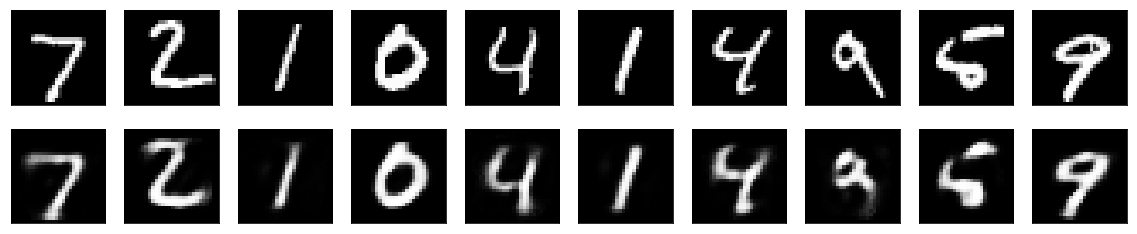

In [9]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Sample generation with Autoencoder 

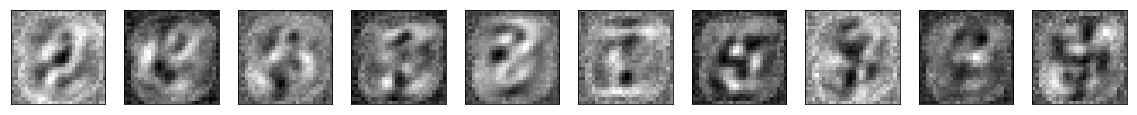

In [10]:
encoded_imgs = np.random.rand(10,32)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # generation
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

## Convolutional AutoEncoder

Since our inputs are images, it makes sense to use convolutional neural networks (`convnets`) as encoders and decoders. 

In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.



In [11]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [12]:
from keras import backend as K

if K.image_data_format() == 'channels_last':
    shape_ord = (28, 28, 1)
else:
    shape_ord = (1, 28, 28)
    
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, ((x_train.shape[0],) + shape_ord))  
x_test = np.reshape(x_test, ((x_test.shape[0],) + shape_ord)) 

In [13]:
x_train.shape

(60000, 28, 28, 1)

In [16]:
from keras.callbacks import TensorBoard

In [17]:
batch_size=128
steps_per_epoch = np.int(np.floor(x_train.shape[0] / batch_size))
conv_autoencoder.fit(x_train, x_train, epochs=1, batch_size=128,
                     shuffle=True, validation_data=(x_test, x_test),
                     callbacks=[TensorBoard(log_dir='./tf_autoencoder_logs')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 49s 810us/step - loss: 0.1255 - val_loss: 0.1232


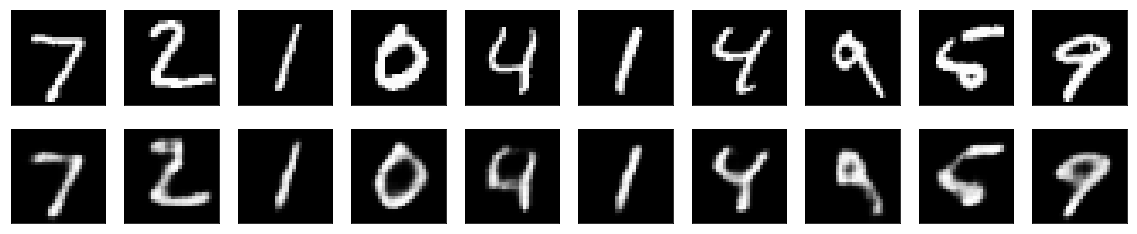

In [18]:
decoded_imgs = conv_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We coudl also have a look at the `128-`dimensional encoded middle representation

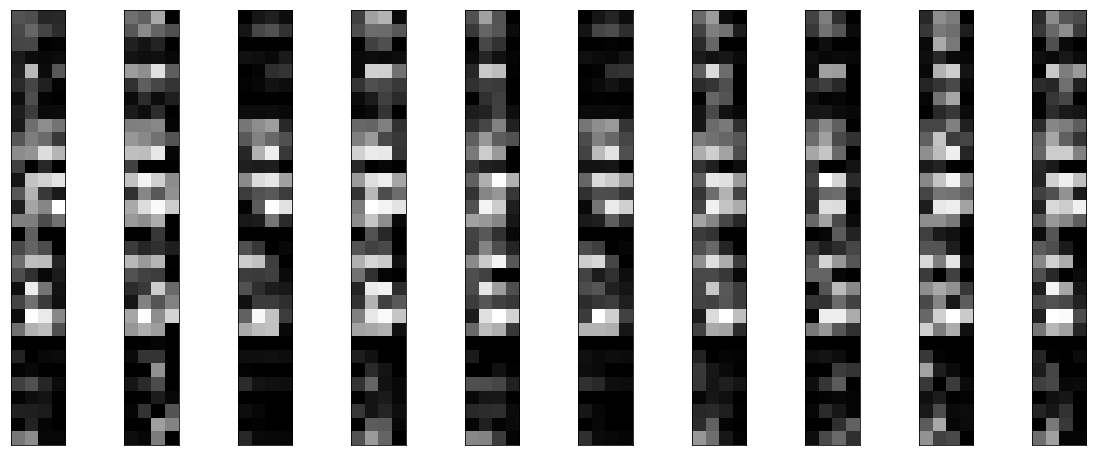

In [19]:
conv_encoder = Model(input_img, encoded)
encoded_imgs = conv_encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Pretraining encoders 

One of the powerful tools of auto-encoders is using the encoder to generate meaningful representation from the feature vectors.

In [20]:
# Use the encoder to pretrain a classifier 

---

## Application to Image Denoising

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's how the noisy digits look like:

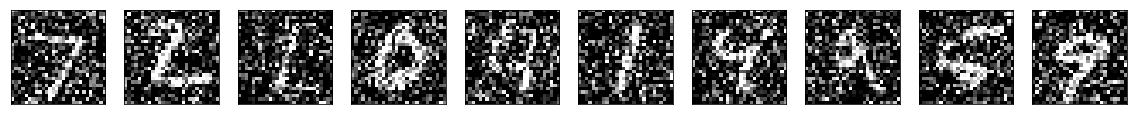

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Question

If you squint you can still recognize them, but barely. 

**Can our autoencoder learn to recover the original digits? Let's find out.**

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's train the AutoEncoder for `100` epochs

In [3]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder_denoise', 
                                       histogram_freq=0, write_graph=False)])

NameError: name 'x_train_noisy' is not defined

### Now Let's Take a look....

In [4]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'x_test_noisy' is not defined

# Variational AutoEncoder

_(Reference [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html))_

Variational autoencoders are a slightly more modern and interesting take on autoencoding.

### What is a variational autoencoder ? 

It's a type of autoencoder with added constraints on the encoded representations being learned. 

More precisely, it is an autoencoder that learns a [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model) for its input data. 

So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. 

If you sample points from this distribution, you can generate new input data samples: 
a **VAE** is a **"generative model"**.

### How does a variational autoencoder work?

First, an encoder network turns the input samples $x$ into two parameters in a latent space, which we will note $z_{\mu}$ and $z_{log_{\sigma}}$. 

Then, we randomly sample similar points $z$ from the _latent normal distribution_ that is assumed to generate the data, via $z = z_{\mu} + \exp(z_{log_{\sigma}}) * \epsilon$, where $\epsilon$ is a random normal tensor. 

Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: 

* a **reconstruction loss** forcing the decoded samples to match the initial inputs (just like in our previous autoencoders);
* and the **KL divergence** between the learned latent distribution and the prior distribution, acting as a regularization term. 

You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

## Encoder Network

In [5]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [6]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

We can use these parameters to sample new similar points from the latent space:

In [7]:
from keras.layers.core import Lambda
from keras import backend as K

In [8]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

## Decoder Network

Finally, we can map these sampled latent points back to reconstructed inputs:

In [9]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

What we've done so far allows us to instantiate 3 models:

- an end-to-end autoencoder mapping inputs to reconstructions
- an encoder mapping inputs to the latent space
- a generator that can take points on the latent space and will output the corresponding reconstructed samples.

In [10]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### Let's Visualise the VAE Model

In [12]:
!pip install pydot 
!pip install graphviz

    100% |████████████████████████████████| 133kB 3.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for pydot ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/62/48/83/42bc8712cb5f9bb93b8f3804e84b31024046981097729ff44e
Successfully built pydot


In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [10]:
## Exercise: Let's Do the Same for `encoder` and `generator` Model(s)



### VAE on MNIST

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [15]:
from keras.objectives import binary_crossentropy

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

Traing on MNIST Digits

In [17]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 108us/step - loss: 0.2631 - val_loss: 0.2627
Epoch 2/50
60000/60000 [==============================] - 7s 111us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 3/50
60000/60000 [==============================] - 7s 115us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 4/50
60000/60000 [==============================] - 7s 116us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 5/50
60000/60000 [==============================] - 7s 113us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 6/50
60000/60000 [==============================] - 7s 112us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 7/50
60000/60000 [==============================] - 7s 110us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 8/50
60000/60000 [==============================] - 7s 112us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 9/50
60000/60000 [==============================] - 7s 118us/step - loss: 0.2629 - val_loss: 0.2

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. 

One is to look at the neighborhoods of different classes on the latent 2D plane:

In [18]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

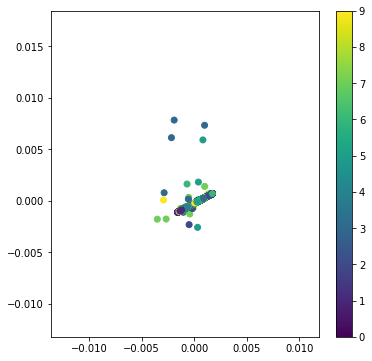

In [20]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).


Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

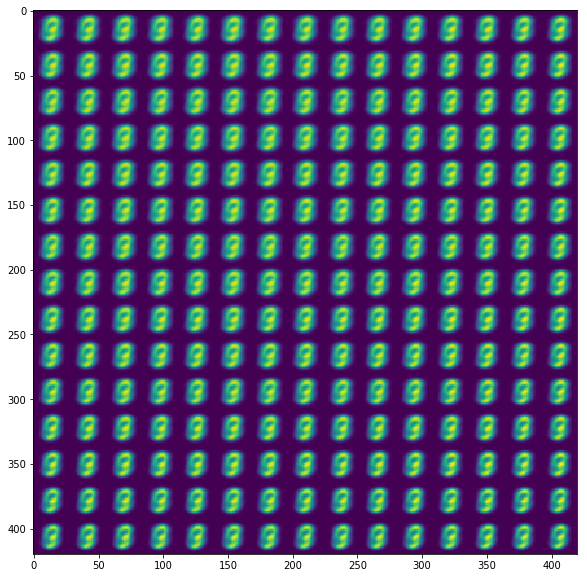

In [21]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()